In [1]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

In [16]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

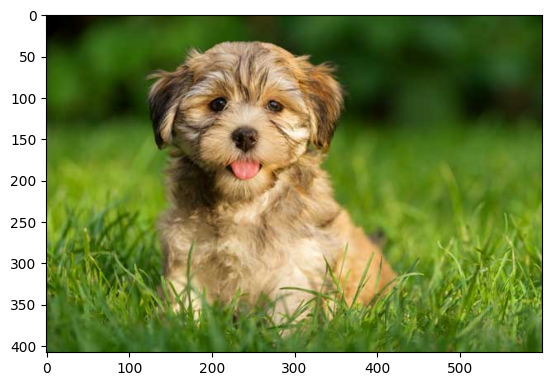

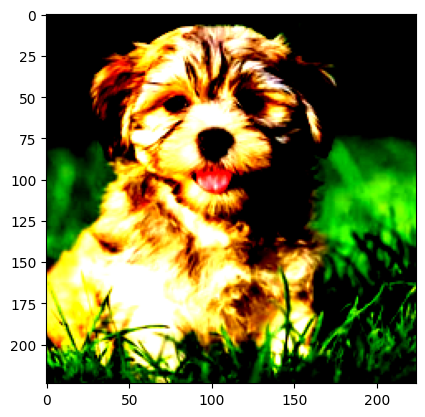

In [17]:
img_file_path = './data/cute-puppy-body-image.jpg'
img =Image.open(img_file_path)

plt.imshow(img)
plt.show()

resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)
img_transformed = transform(img, phase="train")

#(channel, height, width) -> (height, width, channel) - > (0,1)
img_transformed= img_transformed.numpy().transpose(1,2,0)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [18]:
def make_datapath_list(phase="train"):
    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+"/**/*.jpg")

    path_list = []

    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list

In [19]:
path_list = make_datapath_list("train")

In [20]:
len(path_list)

243

In [21]:
path_list[:10]

['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg']

In [22]:
train_list = make_datapath_list("train")
val_list = make_datapath_list("val")

In [31]:
class MyDataset(data.Dataset):
    def __init__(self, file_list, transform =None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)

        img_transformed = self.transform(img, self.phase)

        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
        
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1
            
        return img_transformed, label

In [32]:
train_dataset = MyDataset(train_list, transform=ImageTransform(resize, mean, std), phase="train")

In [33]:
val_dataset = MyDataset(val_list, transform=ImageTransform(resize, mean, std), phase="val")

In [39]:
index = 242
# print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape)
print(label)

torch.Size([3, 224, 224])
1


In [40]:
index = 0
# print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


In [42]:
batch_size = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

dataloader_dict = {"train":train_dataloader, "val":val_dataloader}

In [43]:
batch_iterator = iter(dataloader_dict["train"])
inputs, labels = next(batch_iterator)

In [44]:
print(inputs.size()) # inputs.shape
print(labels)

torch.Size([4, 3, 224, 224])
tensor([0, 0, 1, 0])
